In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from deep_generative_models.dataset import create_dataloader

In [8]:
"""
class VAE(nn.Module):
    def __init__(self, input_dim=128, last_hidden_dim=128):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        #wenn zeit ist mit cnns statt linear
        self.encoder = nn.Sequential(
            nn.Linear(input_dim**2, last_hidden_dim*10), #anzahl der layers und dimension variabel machen
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim*10, last_hidden_dim*5),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim*5, last_hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*2, last_hidden_dim),
            nn.LeakyReLU(0.2)
            )  
        # man kann nicht den mean und varianz berechnen sonst stimmen die dimensionen nicht evtll später mit mean und var in einem vektor probieren
        self.mean = nn.Linear(last_hidden_dim, last_hidden_dim)
        self.var = nn.Linear(last_hidden_dim, last_hidden_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(last_hidden_dim, last_hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*2, last_hidden_dim*5),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*5, last_hidden_dim*10),
            nn.LeakyReLU(0.2),
            nn.Linear(last_hidden_dim*10, input_dim**2),
            )    
        
    def encode(self, x): 
        x = x.view(x.size(0), -1)     
        x = self.encoder(x)
        var = self.var(x)
        var = torch.clamp(var, min=1e-6) #sont kann KL nan ausgeben wegen negativem log
        mean = self.mean(x)
        return var, mean
        
    def reparameterization(self, mean, var):
        self.norm = torch.distributions.Normal(0, 1)
        epsilon = self.norm.sample(var.shape)   
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        var, mean = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        x_hat = x_hat.reshape((-1, 1, self.input_dim, self.input_dim))
        return x_hat, mean, var
"""
class VAE(nn.Module):
    def __init__(self, input_dim=128, last_hidden_dim=128):
        super(VAE, self).__init__()
        self.input_dim = input_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.Flatten(),
        )

        self.flattened_dim = (input_dim // 8) * (input_dim // 8) * 128

        self.mean = nn.Linear(self.flattened_dim, last_hidden_dim)
        self.var = nn.Linear(self.flattened_dim, last_hidden_dim)

        self.decoder_input = nn.Linear(last_hidden_dim, self.flattened_dim)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, input_dim // 8, input_dim // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  
        )

    def encode(self, x):
        x = self.encoder(x)
        var = torch.clamp(self.var(x), min=1e-6)
        mean = self.mean(x)
        return var, mean

    def reparameterization(self, mean, var):
        self.norm = torch.distributions.Normal(0, 1)
        epsilon = self.norm.sample(var.shape) 
        z = mean + var * epsilon
        return z

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        var, mean = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var

In [9]:
def loss_function(x, x_hat, mean, var, model):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(2*torch.log(var) - mean*mean - var*var + 1)
    l2_reg = sum(torch.sum(param**2) for param in model.parameters())
    return reproduction_loss + KLD + l2_reg*1e-6 

In [10]:
brains = ['B01', 'B02', 'B05']  # Training brains
brains = ["B20"]
hdf5_file_path = 'data/cell_data.h5'
tile_size = 128
batch_size = 32
tiles_per_epoch = 100
dataloader = create_dataloader(hdf5_file_path, brains, tile_size, batch_size, tiles_per_epoch, num_workers=0)

model = VAE(input_dim=tile_size, last_hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

In [11]:
def train(model, dataloader, optimizer, loss_function, epochs, batch_size):
    epoch_losses = []
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for i, x in enumerate(dataloader):
            optimizer.zero_grad()
            x_hat, mean, var = model(x)
            loss = loss_function(x, x_hat, mean, var, model)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()
        average_loss = overall_loss / len(dataloader)
        epoch_losses.append(average_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}")
    
    return epoch_losses
    
train(model, dataloader, optimizer, loss_function, epochs, batch_size)

Epoch 1/30, Average Loss: 941370.5898
Epoch 2/30, Average Loss: 785835.3789
Epoch 3/30, Average Loss: 751108.4375
Epoch 4/30, Average Loss: 558977.9297
Epoch 5/30, Average Loss: 555269.1953
Epoch 6/30, Average Loss: 543628.7529
Epoch 7/30, Average Loss: 438011.7764
Epoch 8/30, Average Loss: 482644.5703
Epoch 9/30, Average Loss: 506586.2109
Epoch 10/30, Average Loss: 865788.8418
Epoch 11/30, Average Loss: 645900.2988
Epoch 12/30, Average Loss: 648215.5000
Epoch 13/30, Average Loss: 657509.6758
Epoch 14/30, Average Loss: 656251.6406
Epoch 15/30, Average Loss: 511307.3203
Epoch 16/30, Average Loss: 453752.5430
Epoch 17/30, Average Loss: 530493.6006
Epoch 18/30, Average Loss: 460002.2930
Epoch 19/30, Average Loss: 444840.7734
Epoch 20/30, Average Loss: 433920.8828
Epoch 21/30, Average Loss: 439482.2129
Epoch 22/30, Average Loss: 442662.4062
Epoch 23/30, Average Loss: 397126.4590
Epoch 24/30, Average Loss: 389559.1826
Epoch 25/30, Average Loss: 403953.7500
Epoch 26/30, Average Loss: 370359.

[941370.58984375,
 785835.37890625,
 751108.4375,
 558977.9296875,
 555269.1953125,
 543628.7529296875,
 438011.7763671875,
 482644.5703125,
 506586.2109375,
 865788.841796875,
 645900.298828125,
 648215.5,
 657509.67578125,
 656251.640625,
 511307.3203125,
 453752.54296875,
 530493.6005859375,
 460002.29296875,
 444840.7734375,
 433920.8828125,
 439482.212890625,
 442662.40625,
 397126.458984375,
 389559.1826171875,
 403953.75,
 370359.34375,
 366158.6025390625,
 363529.623046875,
 370679.1162109375,
 377832.23046875]

Original batch shape: torch.Size([32, 1, 128, 128])


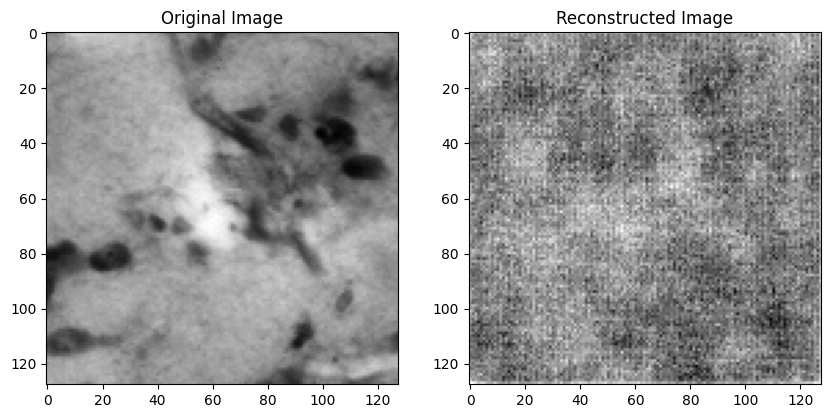

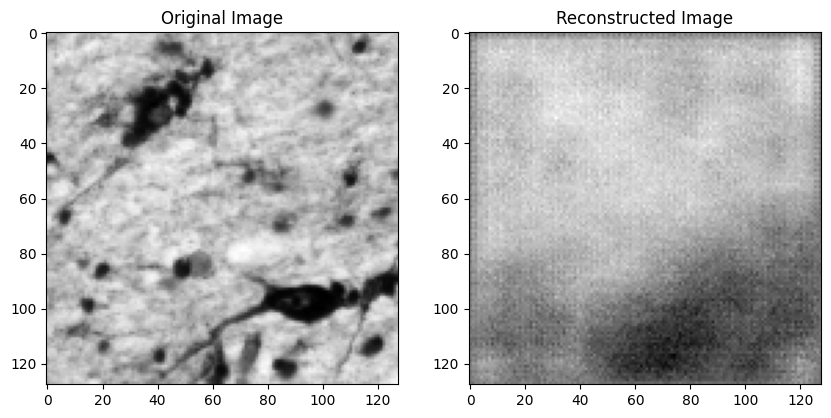

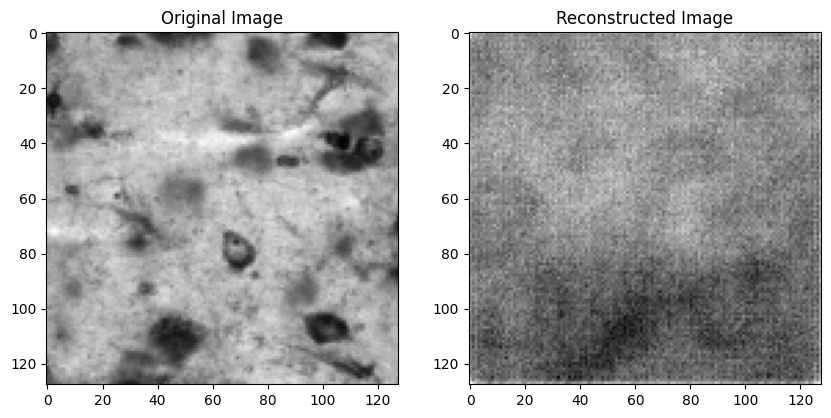

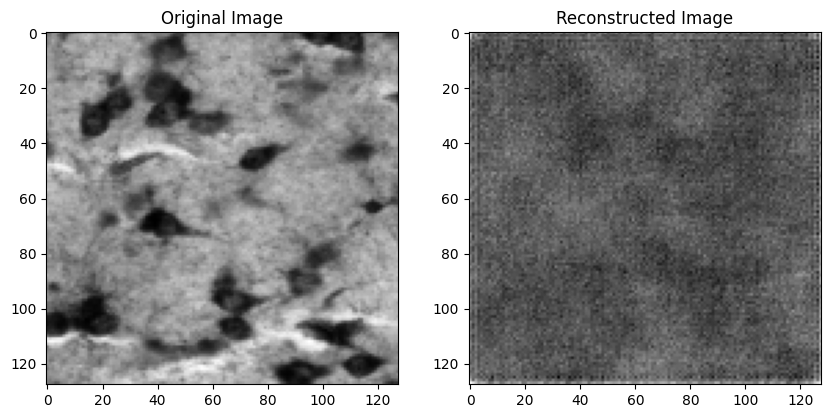

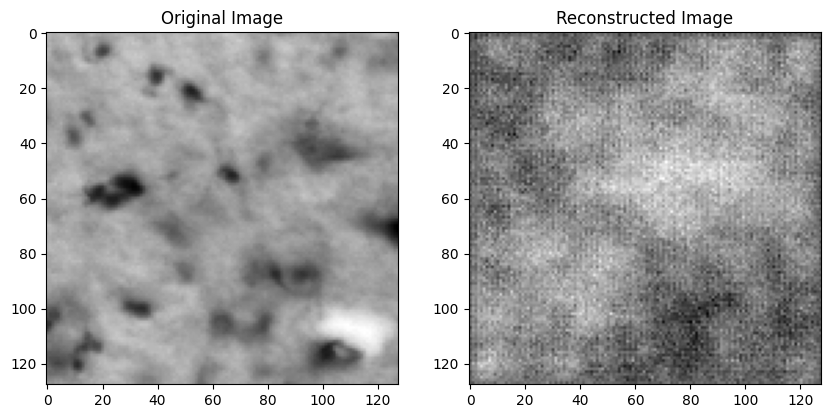

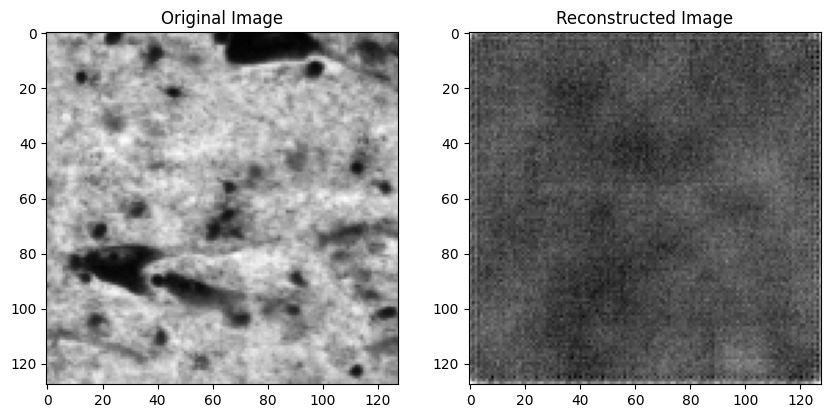

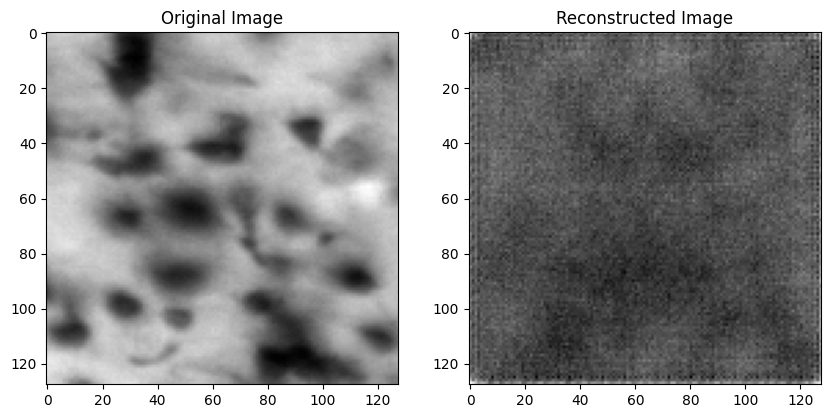

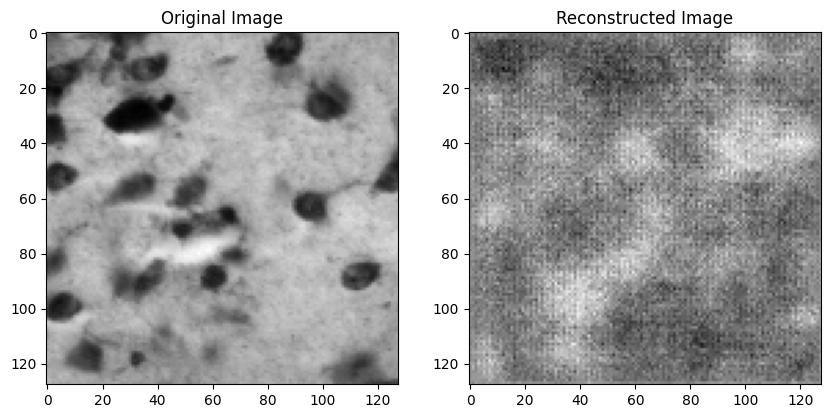

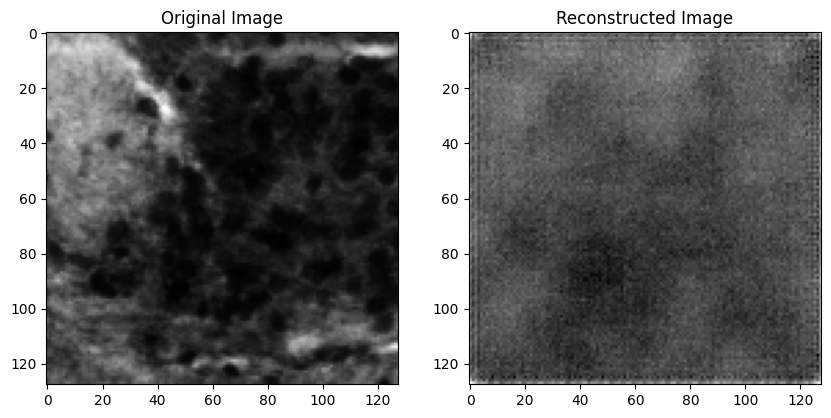

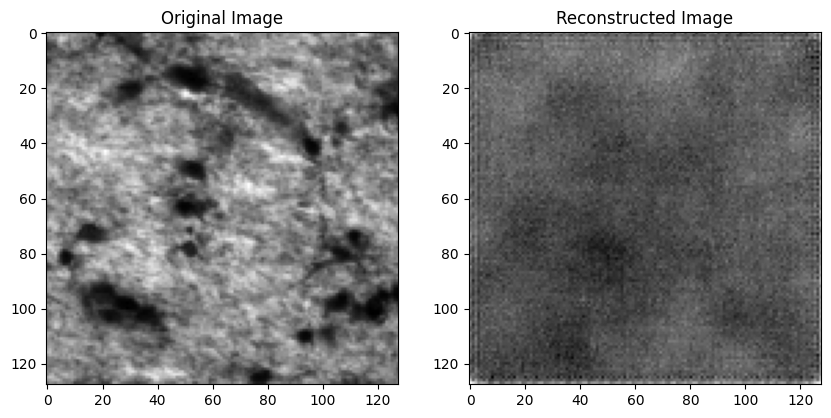

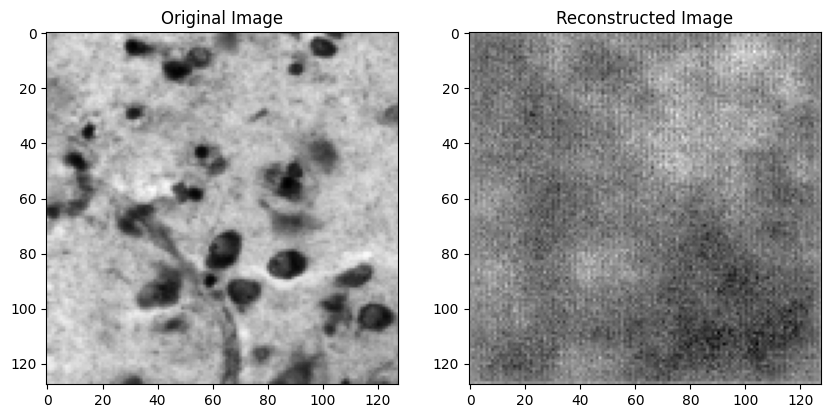

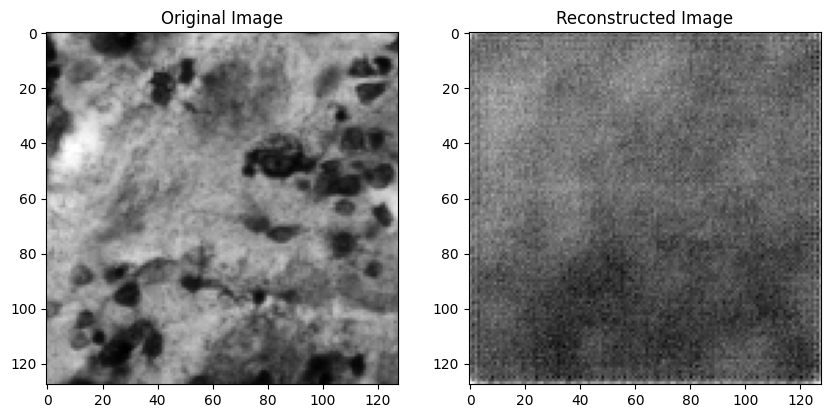

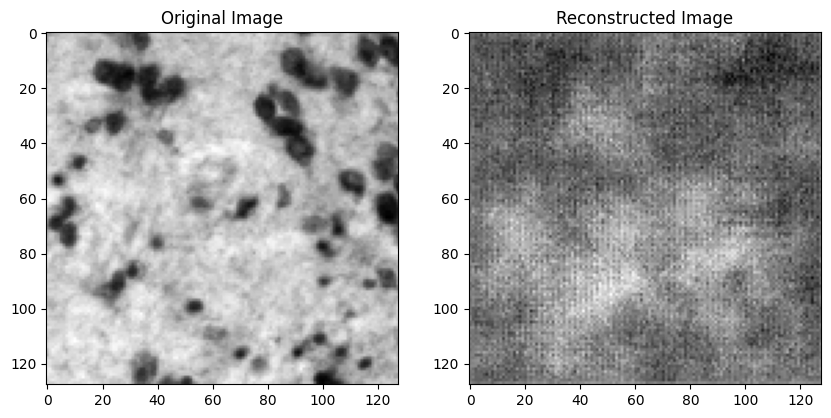

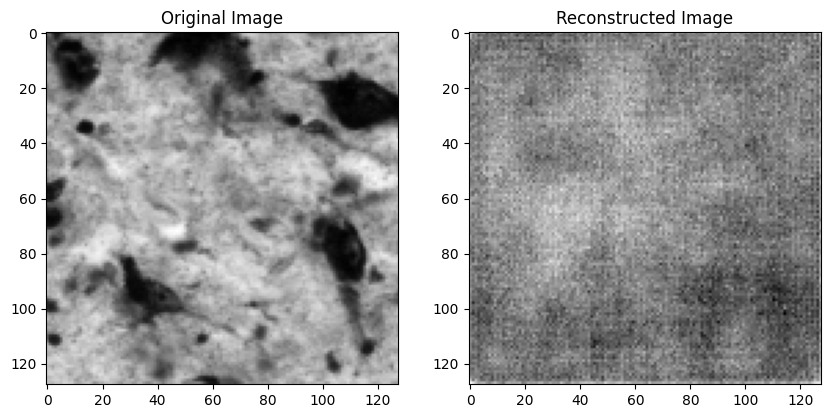

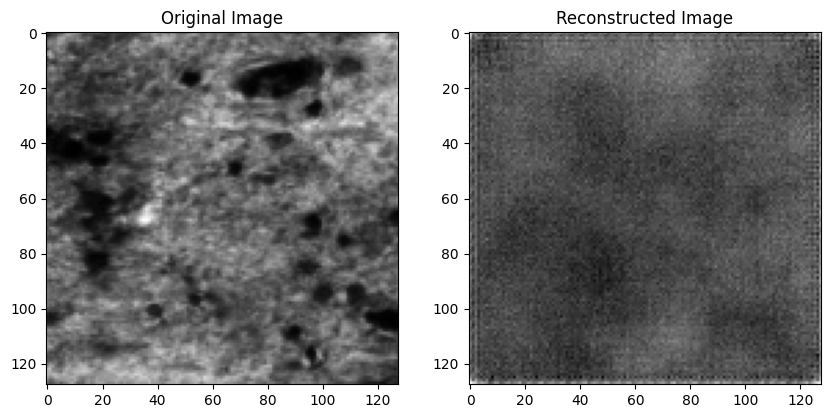

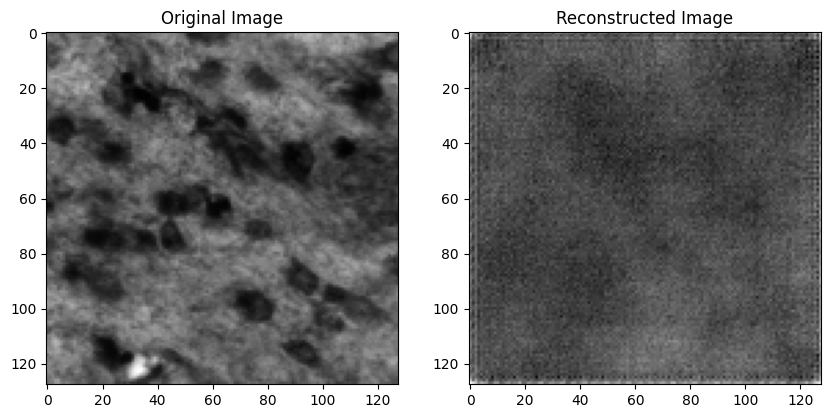

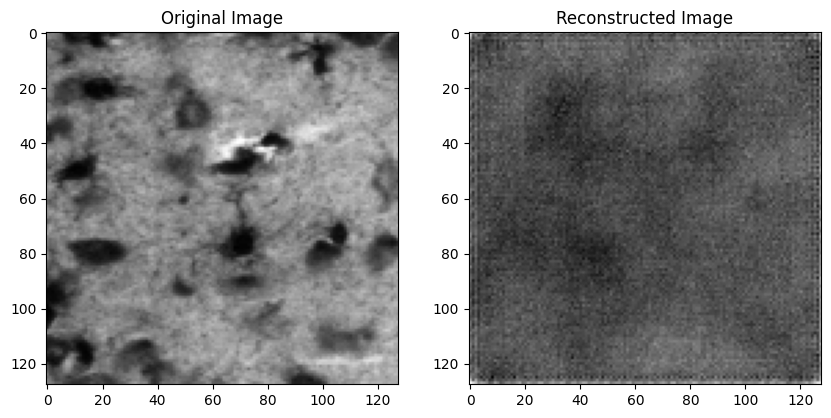

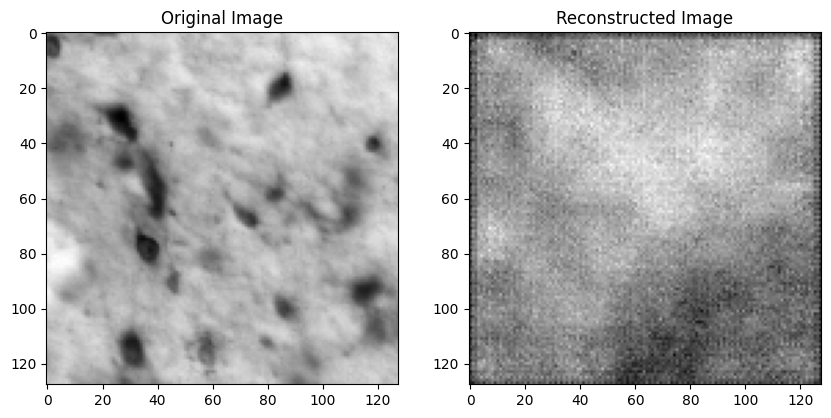

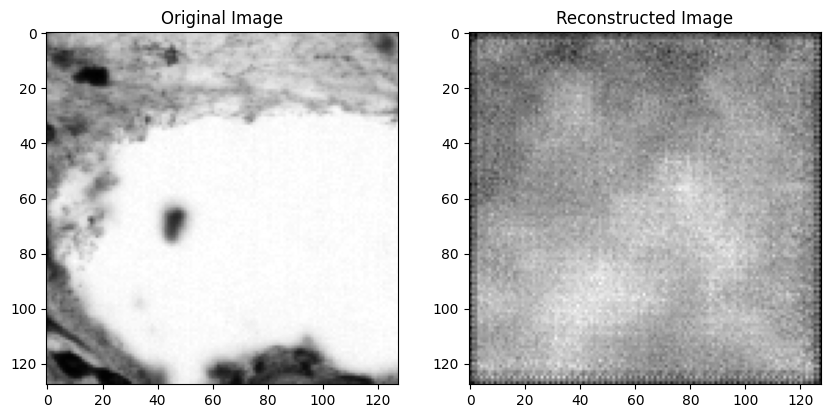

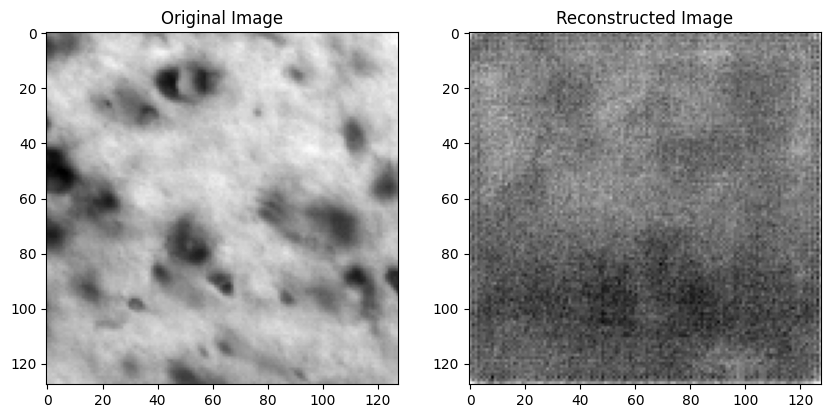

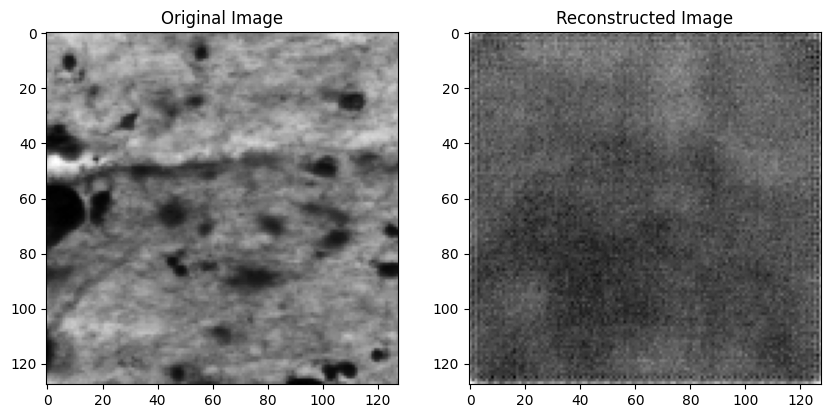

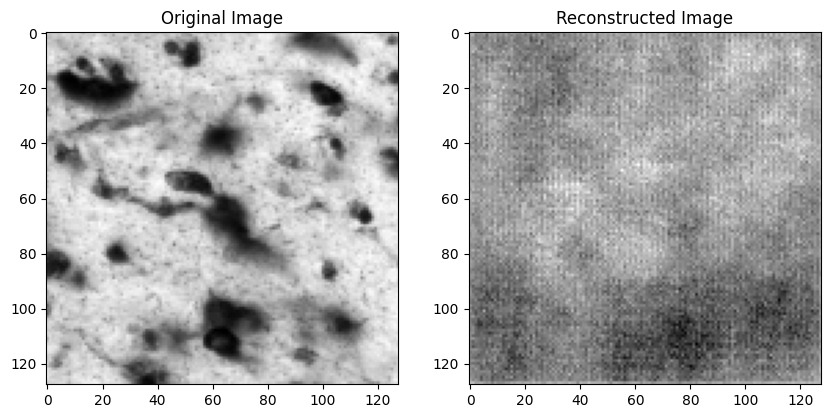

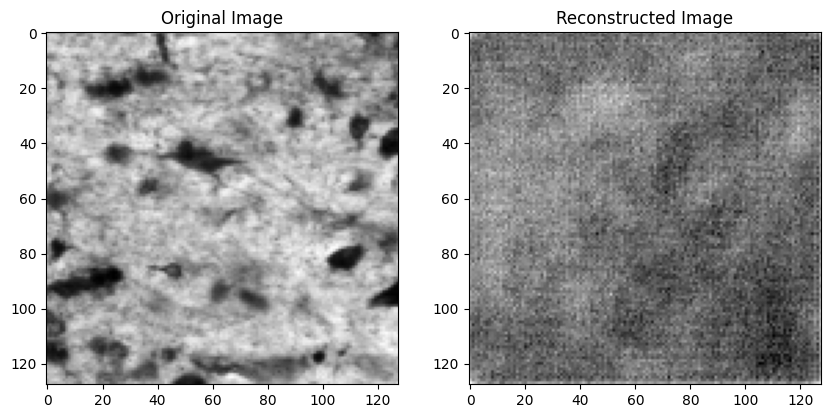

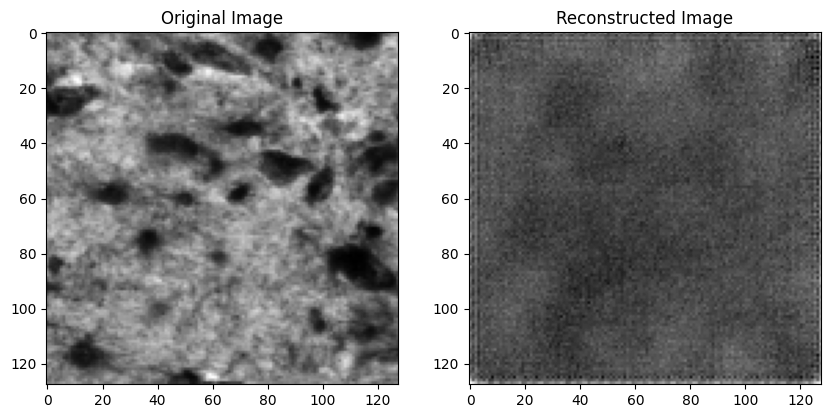

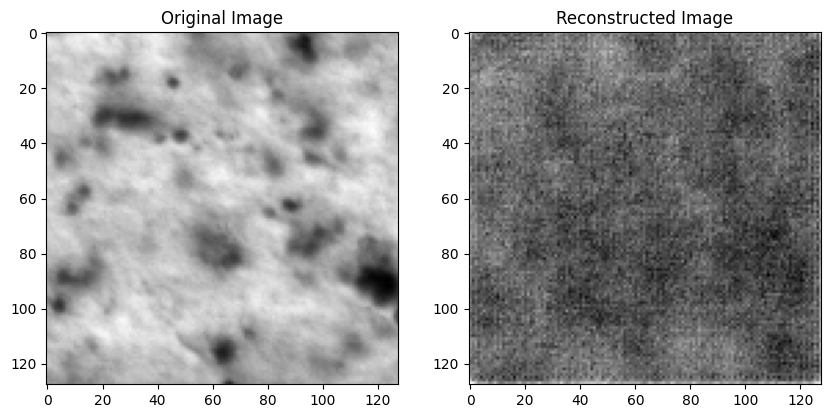

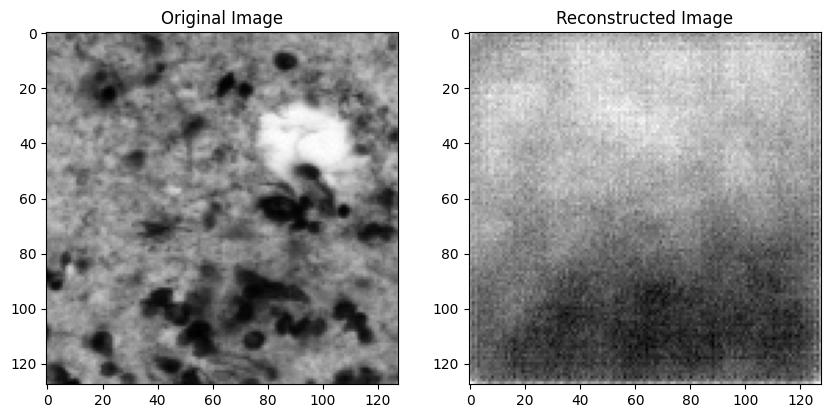

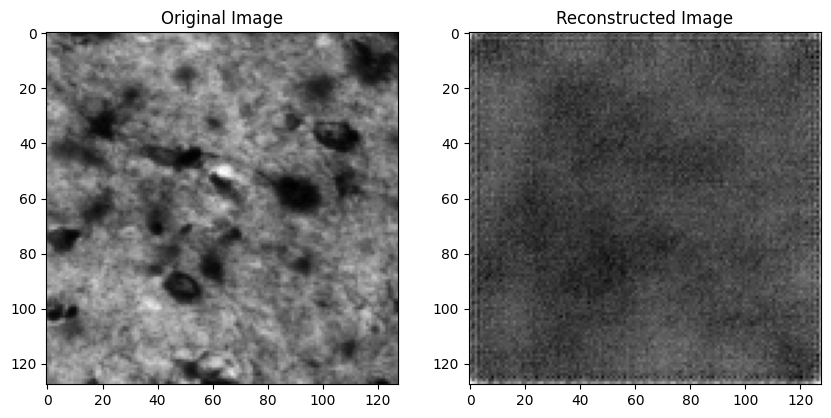

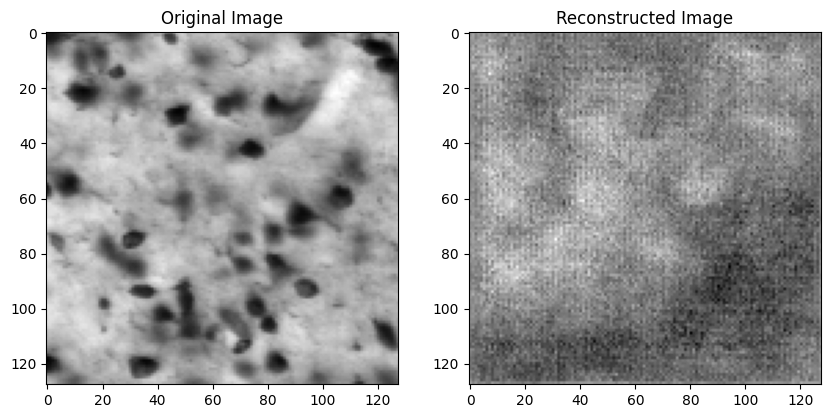

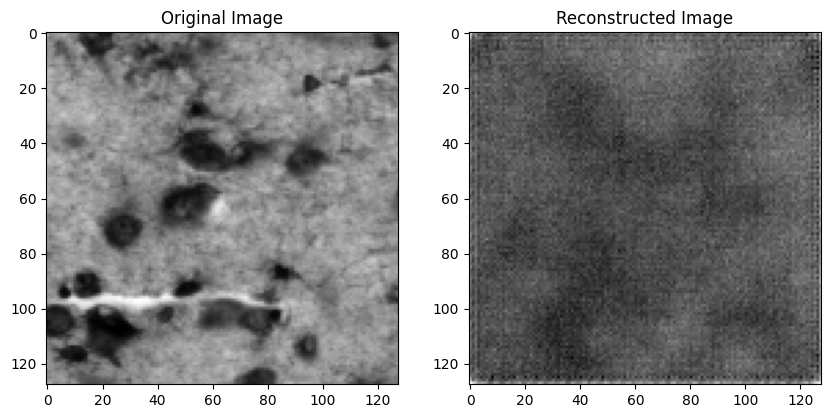

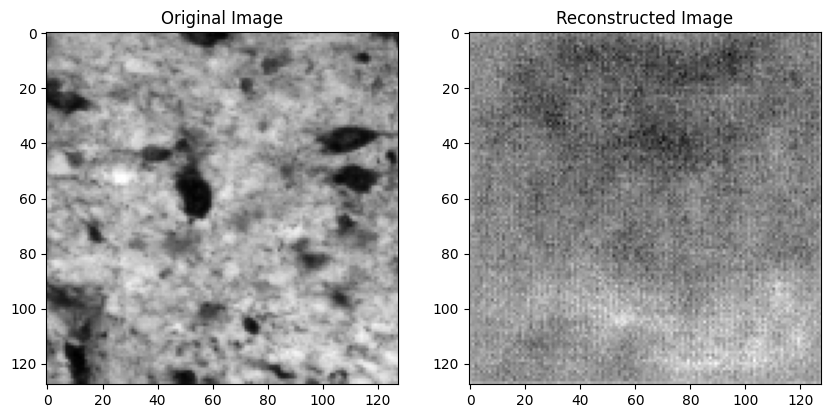

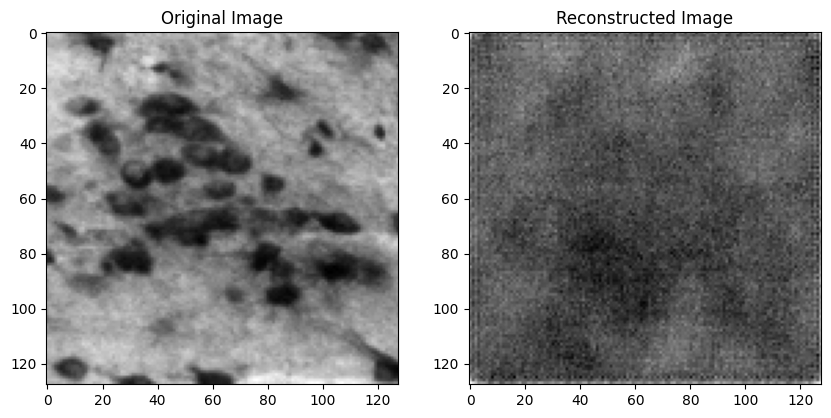

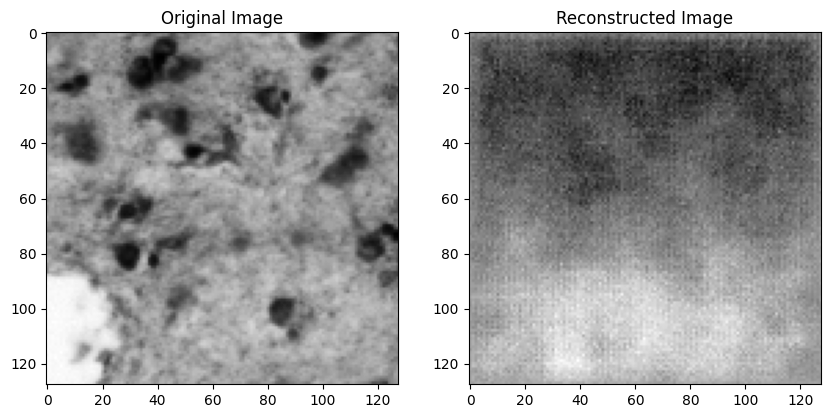

In [12]:
import matplotlib.pyplot as plt
import torch

for batch in dataloader:
    images = batch  
    print(f"Original batch shape: {images.shape}")
    x_hat, mean, var = model(images)
    reconstructed_images = x_hat.view(batch_size, 128, 128)

    for i in range(batch_size):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(images[i].squeeze().numpy(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].imshow(reconstructed_images[i].detach().numpy(), cmap='gray')
        ax[1].set_title("Reconstructed Image")
        plt.show()
    
    break  
